<a href="https://colab.research.google.com/github/nikhil6553/studious-waffle/blob/main/Amazon_Delivery_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from datetime import datetime, timedelta
import math

In [2]:
# helper: haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


In [4]:
df=pd.read_csv("/content/amazon_delivery.csv")

In [5]:
print(df.head())
print(df.info())

        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle

In [6]:
df.drop_duplicates(inplace=True)

In [9]:
# Handle missing values
df.fillna({
    "Agent_Rating": df["Agent_Rating"].mean(),
    "Agent_Age": df["Agent_Age"].median(),
    "Traffic": "Low",
    "Weather": "Clear"
}, inplace=True)

In [10]:
# Calculate distance
df["Distance_km"] = haversine(
    df["Store_Latitude"], df["Store_Longitude"],
    df["Drop_Latitude"], df["Drop_Longitude"]
)

In [13]:
# Parse datetime
df["Order_DateTime"] = pd.to_datetime(df["Order_Date"] + " " + df["Order_Time"])
df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"])

df["Order_Hour"] = df["Order_DateTime"].dt.hour
df["Order_DayOfWeek"] = df["Order_DateTime"].dt.dayofweek

/tmp/ipython-input-594615258.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], errors='coerce')


In [17]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

cat_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [19]:
# Drop unused columns
drop_cols = ["Order_ID", "Order_Date", "Order_Time", "Store_Latitude", "Store_Longitude",
             "Drop_Latitude", "Drop_Longitude", "Order_DateTime", "Pickup_Time"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

In [20]:
# train_models.py
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from data_preparation import preprocess_data
import joblib

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def train_and_log_models(file_path="amazon_delivery.csv"):
    df, _ = preprocess_data(file_path)
    X = df.drop(columns=["Delivery_Time"])
    y = df["Delivery_Time"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(random_state=42)
    }

    mlflow.set_experiment("Amazon_Delivery_Prediction")

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model.fit(X_train, y_train)
            metrics = evaluate_model(model, X_test, y_test)
            mlflow.log_params(model.get_params())
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(model, name)
            print(f"{name} -> MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.3f}")

            # Save model locally
            joblib.dump(model, f"{name}_model.pkl")

if __name__ == "__main__":
    train_and_log_models()

ModuleNotFoundError: No module named 'mlflow'

In [24]:
%%writefile data_preparation.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import math

# helper: haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

def preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Handle missing values
    df.fillna({
        "Agent_Rating": df["Agent_Rating"].mean(),
        "Agent_Age": df["Agent_Age"].median(),
        "Traffic": "Low",
        "Weather": "Clear"
    }, inplace=True)

    # Calculate distance
    df["Distance_km"] = haversine(
        df["Store_Latitude"], df["Store_Longitude"],
        df["Drop_Latitude"], df["Drop_Longitude"]
    )

    # Parse datetime
    df["Order_DateTime"] = pd.to_datetime(df["Order_Date"] + " " + df["Order_Time"], errors='coerce')
    df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], errors='coerce')

    df["Order_Hour"] = df["Order_DateTime"].dt.hour
    df["Order_DayOfWeek"] = df["Order_DateTime"].dt.dayofweek

    # Encode categorical variables
    cat_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
    le_dict = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le

    # Drop unused columns
    drop_cols = ["Order_ID", "Order_Date", "Order_Time", "Store_Latitude", "Store_Longitude",
                 "Drop_Latitude", "Drop_Longitude", "Order_DateTime", "Pickup_Time"]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    return df, le_dict

Writing data_preparation.py


In [21]:
%pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4

In [26]:
# # app.py
# import streamlit as st
# import numpy as np
# import joblib
# import math

# st.set_page_config(page_title="Amazon Delivery Time Prediction", layout="centered")

# st.title("📦 Amazon Delivery Time Prediction")

# # Load model
# model = joblib.load("RandomForest_model.pkl")

# st.sidebar.header("Input Delivery Details")

# distance = st.sidebar.number_input("Distance (km)", 0.1, 50.0, 5.0)
# agent_age = st.sidebar.slider("Agent Age", 18, 60, 30)
# agent_rating = st.sidebar.slider("Agent Rating", 0.0, 5.0, 4.0)
# traffic = st.sidebar.selectbox("Traffic", [0, 1, 2, 3])  # encoded
# weather = st.sidebar.selectbox("Weather", [0, 1, 2, 3])
# vehicle = st.sidebar.selectbox("Vehicle", [0, 1, 2])
# area = st.sidebar.selectbox("Area Type", [0, 1])
# category = st.sidebar.selectbox("Product Category", [0, 1, 2, 3])
# order_hour = st.sidebar.slider("Order Hour", 0, 23, 14)
# order_dow = st.sidebar.slider("Order Day of Week (0=Mon)", 0, 6, 2)

# if st.button("Predict Delivery Time"):
#     input_data = np.array([[agent_age, agent_rating, traffic, weather, vehicle,
#                             area, category, distance, order_hour, order_dow]])
#     pred = model.predict(input_data)[0]
#     st.success(f"⏱ Estimated Delivery Time: {pred:.2f} hours")

2025-10-05 08:22:09.265 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 08:22:09.267 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 08:22:09.385 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-05 08:22:09.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 08:22:09.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


FileNotFoundError: [Errno 2] No such file or directory: 'RandomForest_model.pkl'

In [25]:
%pip install streamlit

In [23]:
%pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.9 MB/s eta 0:00:00


In [27]:
# eda_analysis.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_preparation import preprocess_data

plt.style.use("seaborn-v0_8-darkgrid")

def perform_eda(file_path="amazon_delivery.csv"):
    df, _ = preprocess_data(file_path)

    print("===== Basic Dataset Overview =====")
    print(df.info())
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    print("\n===== Statistical Summary =====")
    print(df.describe())

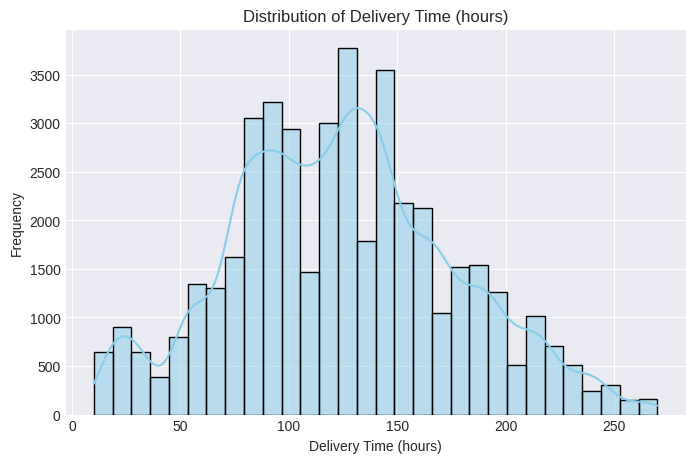

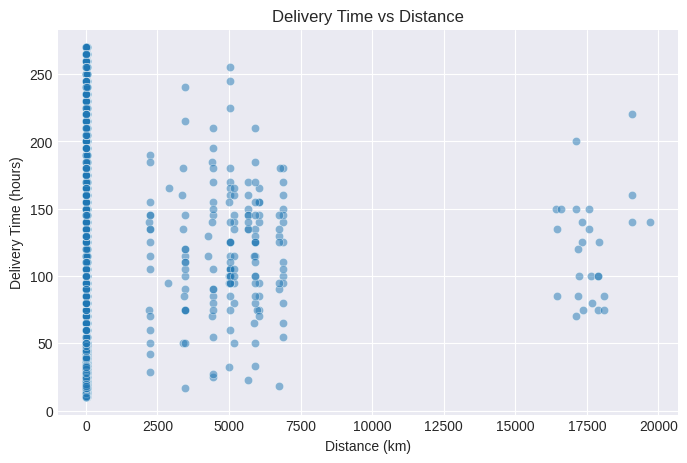

/tmp/ipython-input-2373227738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Weather", y="Delivery_Time", data=df, palette="coolwarm")


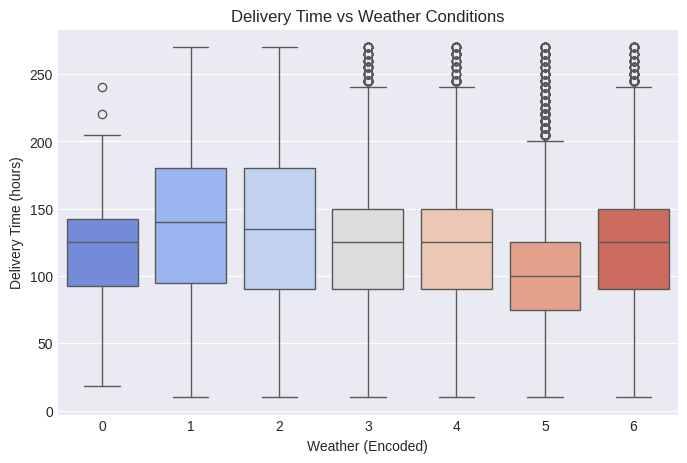

/tmp/ipython-input-2373227738.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Traffic", y="Delivery_Time", data=df, palette="YlOrBr")


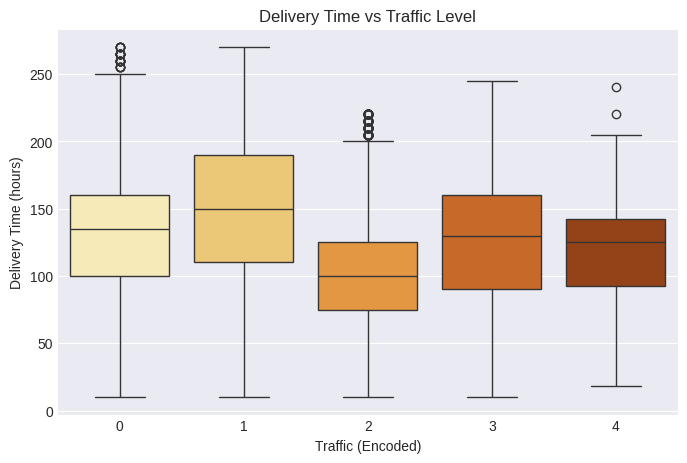

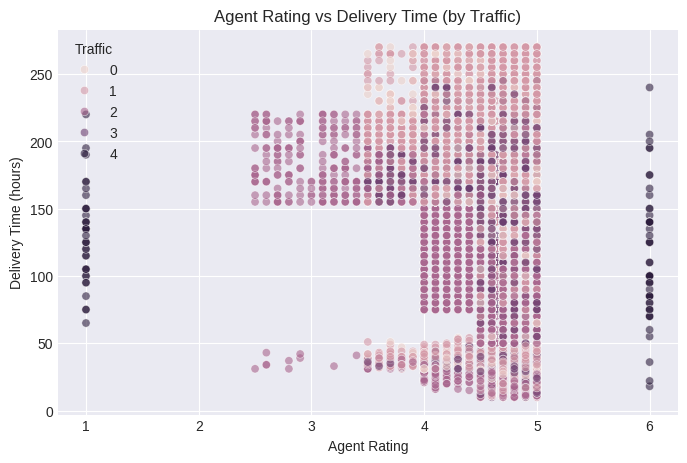

/tmp/ipython-input-2373227738.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Delivery_Time", data=avg_time, palette="viridis")


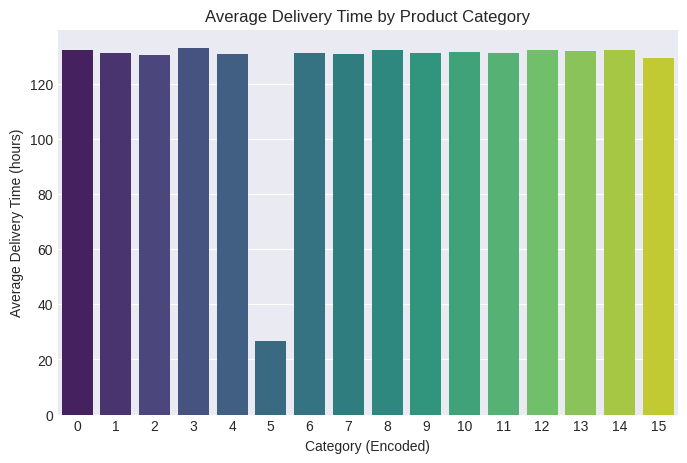

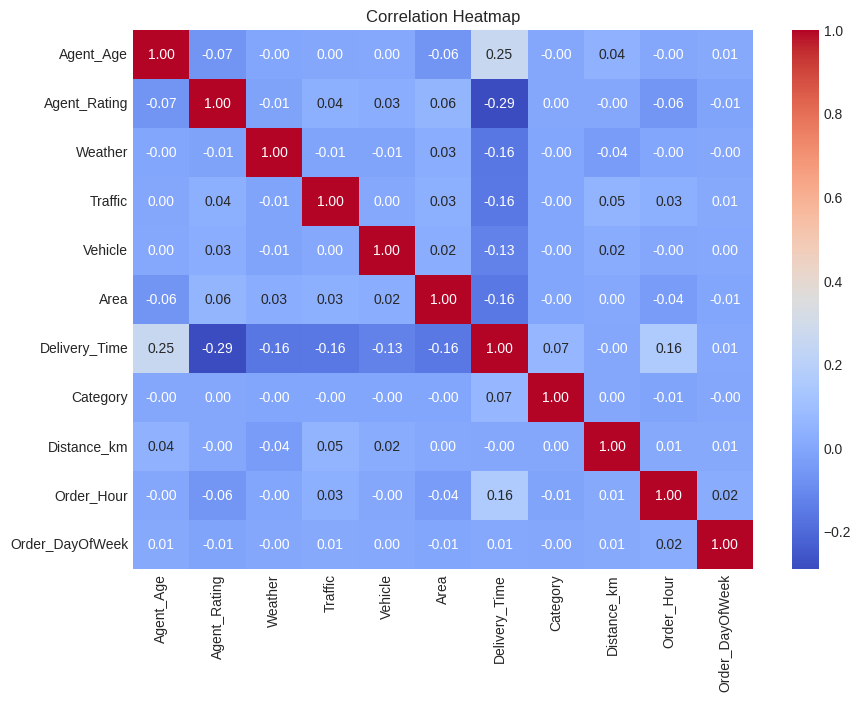


===== Key Observations =====

1. Delivery time tends to increase with distance and traffic levels.
2. Weather conditions like rain or fog increase average delivery time.
3. Agents with higher ratings often have lower delivery times.
4. Product category and area type slightly influence delivery durations.
5. Distance, traffic, and weather show strongest correlation with delivery time.

===== Basic Dataset Overview =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Agent_Age        43739 non-null  int64  
 1   Agent_Rating     43739 non-null  float64
 2   Weather          43739 non-null  int64  
 3   Traffic          43739 non-null  int64  
 4   Vehicle          43739 non-null  int64  
 5   Area             43739 non-null  int64  
 6   Delivery_Time    43739 non-null  int64  
 7   Category         43739 non-null  int64  
 8   Di

/content/data_preparation.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], errors='coerce')


In [30]:
# Delivery Time Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(df["Delivery_Time"], kde=True, bins=30, color="skyblue")
plt.title("Distribution of Delivery Time (hours)")
plt.xlabel("Delivery Time (hours)")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Delivery Time vs Distance
# -------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Distance_km", y="Delivery_Time", data=df, alpha=0.5)
plt.title("Delivery Time vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (hours)")
plt.show()

# -------------------------------
# Delivery Time by Weather
# -------------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(x="Weather", y="Delivery_Time", data=df, palette="coolwarm")
plt.title("Delivery Time vs Weather Conditions")
plt.xlabel("Weather (Encoded)")
plt.ylabel("Delivery Time (hours)")
plt.show()

# -------------------------------
# Delivery Time by Traffic Level
# -------------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(x="Traffic", y="Delivery_Time", data=df, palette="YlOrBr")
plt.title("Delivery Time vs Traffic Level")
plt.xlabel("Traffic (Encoded)")
plt.ylabel("Delivery Time (hours)")
plt.show()

# -------------------------------
# Agent Performance
# -------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=df, hue="Traffic", alpha=0.6)
plt.title("Agent Rating vs Delivery Time (by Traffic)")
plt.xlabel("Agent Rating")
plt.ylabel("Delivery Time (hours)")
plt.show()

# -------------------------------
# Average Delivery Time by Product Category
# -------------------------------
plt.figure(figsize=(8, 5))
avg_time = df.groupby("Category")["Delivery_Time"].mean().reset_index()
sns.barplot(x="Category", y="Delivery_Time", data=avg_time, palette="viridis")
plt.title("Average Delivery Time by Product Category")
plt.xlabel("Category (Encoded)")
plt.ylabel("Average Delivery Time (hours)")
plt.show()

# -------------------------------
# Correlation Heatmap
# -------------------------------
plt.figure(figsize=(10, 7))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

print("\n===== Key Observations =====")
print("""
1. Delivery time tends to increase with distance and traffic levels.
2. Weather conditions like rain or fog increase average delivery time.
3. Agents with higher ratings often have lower delivery times.
4. Product category and area type slightly influence delivery durations.
5. Distance, traffic, and weather show strongest correlation with delivery time.
""")

if __name__ == "__main__":
    perform_eda()